Import the necessary libraries.

In [1]:
import tensorflow as tf # version 2.2.0
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

Directories to image datasets.

In [2]:
image_dir = "C:\\Users\\henry\\Desktop\\AI\\Final_project\\image_data"
data_dir = pathlib.Path(image_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
arts_dir = pathlib.Path(image_dir + "\\arts_image_raw")
cell_dir = pathlib.Path(image_dir + "\\cell_image_raw")
arts_image_count = len(list(arts_dir.glob('*.jpg')))
cell_image_count = len(list(cell_dir.glob('*.jpg')))

Test image and directories. 

RGB JPEG


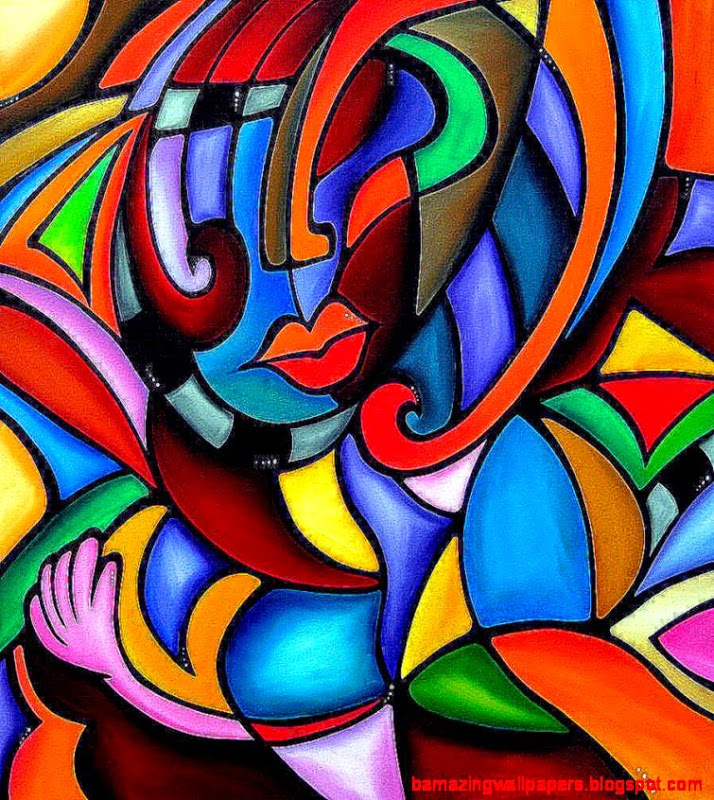

In [3]:
arts = list(data_dir.glob('arts_image_raw/*'))
for image_path in arts[:1]:
    arts_im = Image.open(str(image_path))
    print(arts_im.mode, arts_im.format)
    display.display(arts_im)

RGB JPEG


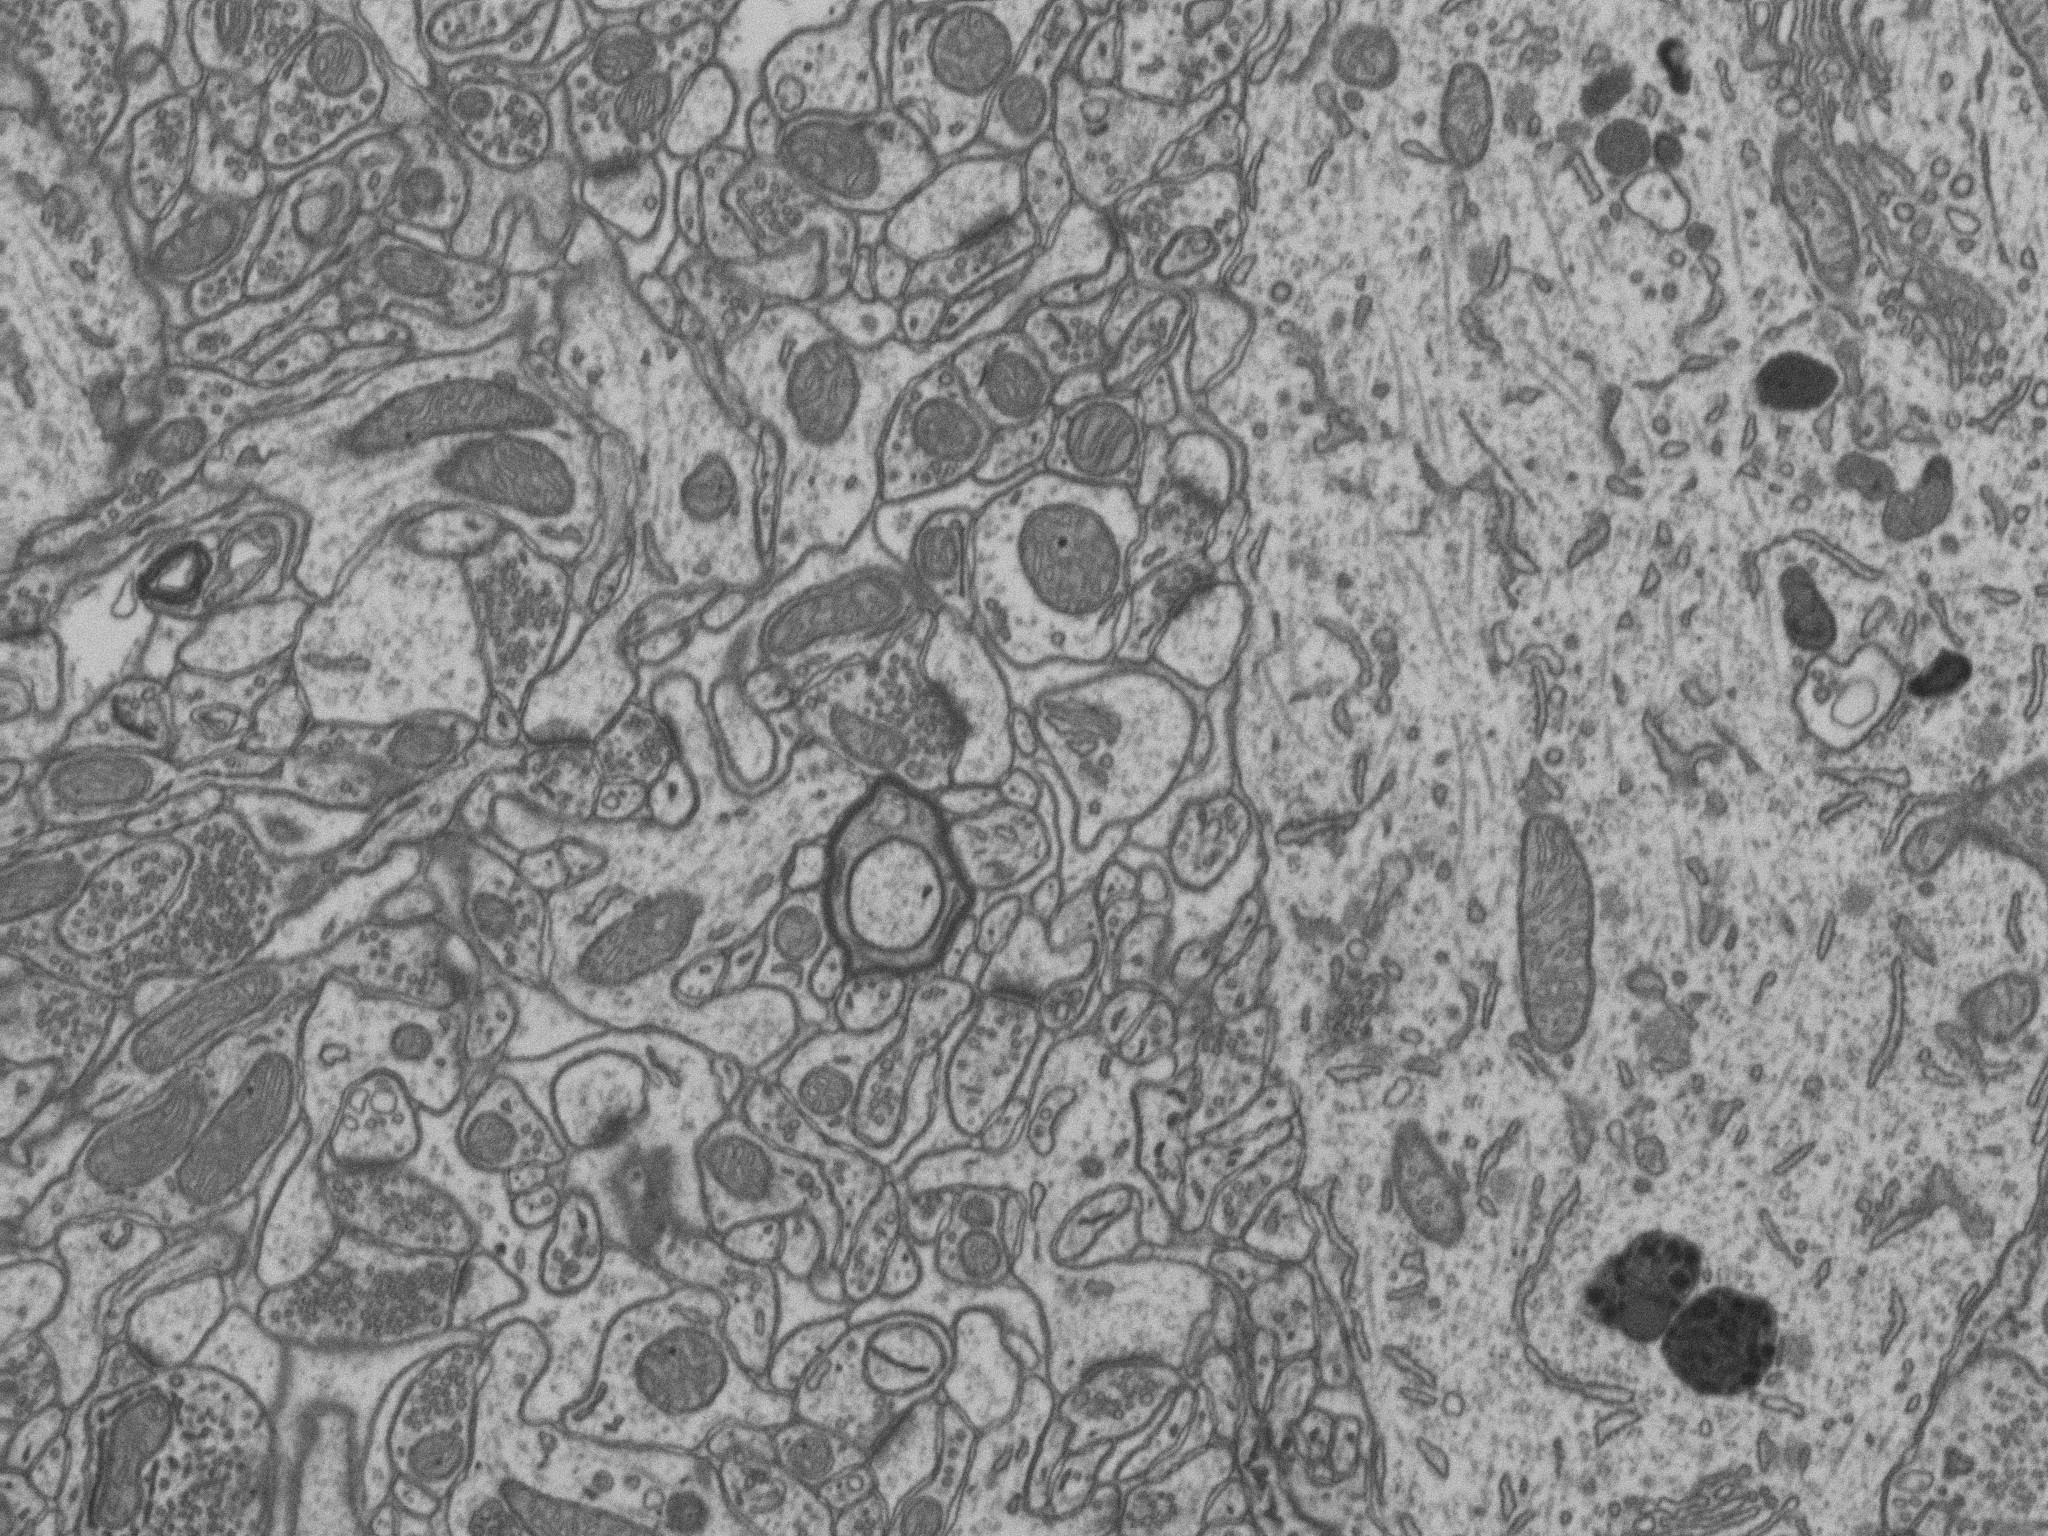

In [4]:
cell = list(data_dir.glob('cell_image_raw/*'))

for image_path in cell[:1]:
    cell_im = Image.open(str(image_path))
    print( cell_im.mode,  cell_im.format)
    display.display(cell_im)
    

Load image data into tensorflow format. Following the tutorial https://www.tensorflow.org/tutorials/load_data/images. Skip the part using keras. 

In [5]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES

array(['arts_image_raw', 'cell_image_raw'], dtype='<U14')

In [6]:
BATCH_SIZE = 1
IMG_HEIGHT = 256
IMG_WIDTH = 256
STEPS_PER_EPOCH = np.ceil(image_count/BATCH_SIZE)
BUFFER_SIZE = 1000


In [7]:
arts_dataset = tf.data.Dataset.list_files(str(arts_dir/'*.jpg'))
cell_dataset = tf.data.Dataset.list_files(str(cell_dir/'*.jpg'))

for f in arts_dataset.take(5):
  print(f.numpy())

for f in cell_dataset.take(5):
  print(f.numpy())

b'C:\\Users\\henry\\Desktop\\AI\\Final_project\\image_data\\arts_image_raw\\5.jpg'
b'C:\\Users\\henry\\Desktop\\AI\\Final_project\\image_data\\arts_image_raw\\3.jpg'
b'C:\\Users\\henry\\Desktop\\AI\\Final_project\\image_data\\arts_image_raw\\8.jpg'
b'C:\\Users\\henry\\Desktop\\AI\\Final_project\\image_data\\arts_image_raw\\4.jpg'
b'C:\\Users\\henry\\Desktop\\AI\\Final_project\\image_data\\arts_image_raw\\0.jpg'
b'C:\\Users\\henry\\Desktop\\AI\\Final_project\\image_data\\cell_image_raw\\volumedata 300.jpg'
b'C:\\Users\\henry\\Desktop\\AI\\Final_project\\image_data\\cell_image_raw\\volumedata 50.jpg'
b'C:\\Users\\henry\\Desktop\\AI\\Final_project\\image_data\\cell_image_raw\\volumedata 450.jpg'
b'C:\\Users\\henry\\Desktop\\AI\\Final_project\\image_data\\cell_image_raw\\volumedata 0.jpg'
b'C:\\Users\\henry\\Desktop\\AI\\Final_project\\image_data\\cell_image_raw\\volumedata 350.jpg'


In [8]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

labeled_arts_dataset = arts_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_cell_dataset = cell_dataset.map(process_path, num_parallel_calls=AUTOTUNE)

Verify data still works and are loaded as desired.

In [9]:
for image, label in labeled_arts_dataset.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
for image, label in labeled_cell_dataset.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (256, 256, 3)
Label:  [ True False]
Image shape:  (256, 256, 3)
Label:  [False  True]


Now follow the tensorflow verison of cycleGAN tutorial https://www.tensorflow.org/tutorials/generative/cyclegan.
Alternatively, refer to its original author's git hub page https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

In [10]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])
  return cropped_image

# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

def preprocess_image_train(image, label):
  image = random_jitter(image)
  #image = normalize(image)
  return image

def preprocess_image_test(image, label):
  # image = normalize(image)
  return image

train_horses = labeled_cell_dataset.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)
train_zebras = labeled_arts_dataset.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)


In [11]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

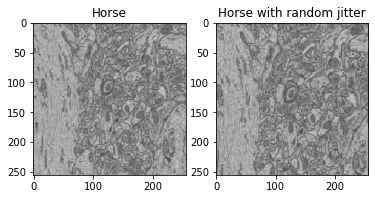

In [12]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] )

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]))

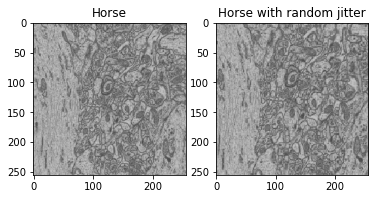

In [13]:
plt.subplot(121)
plt.title('Horse')
plt.imshow(sample_horse[0] )

plt.subplot(122)
plt.title('Horse with random jitter')
plt.imshow(random_jitter(sample_horse[0]) )

Download pix2pix.py from https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py into project directory in order to import it.

In [14]:
import pix2pix
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

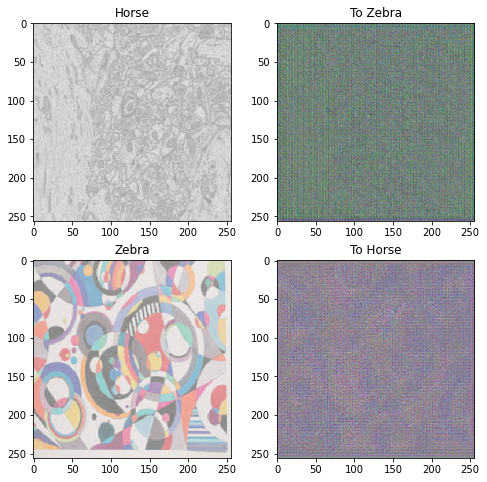

In [15]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0]*0.5+0.5)
  else:
    plt.imshow(imgs[i][0]*0.5+0.5)
plt.show()

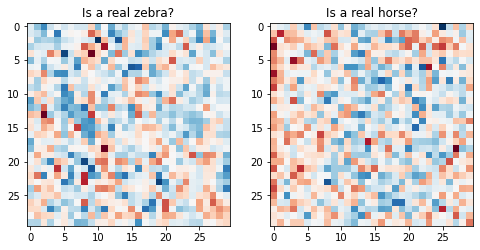

In [16]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [17]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1

def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:

def generate_images(model, test_input):
  prediction = model(test_input)
  plt.figure(figsize=(12, 12))
  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']
  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i])
    plt.axis('off')
  plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

In [ ]:
EPOCHS = 40
import time
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_horses, train_zebras)):
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n+=1

  # clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  # generate_images(generator_g, sample_horse)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

Now Generate Image with the trained cycleGAN

In [ ]:
def get_label_by_name(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-1] 

def process_image_out(file_path):
    img, label = process_path(file_path)
    label = get_label_by_name(file_path)
    img = preprocess_image_test(img, label)
    return img, label

ocell_dir = pathlib.Path("C:\\Users\\henry\\Desktop\\AI\\Final_project\\test_data\\cell_image_raw")
ocell_dataset = tf.data.Dataset.list_files(str(ocell_dir/'*.jpg'), shuffle= False)
labeled_ocell_dataset = ocell_dataset.map(process_path, num_parallel_calls=AUTOTUNE)
train_ocells = labeled_ocell_dataset.map(preprocess_image_test, num_parallel_calls=AUTOTUNE).batch(1)
ocell_iter = iter(train_ocells)

# test_ocells = ocell_dataset.map(process_image_out, num_parallel_calls=AUTOTUNE).batch(1)


count = 0
stop_at = 1068


def getNumStr(i):
    if i < 10: 
        return '000' +  str(i)
    if i >= 10 and i < 100: 
        return '00' +  str(i) 
    if i >= 100 and i < 1000:
        return '0' +  str(i) 
    return str(i) 


while True: 
    try: # Iterate by calling next 
        sample_cell = next(ocell_iter)
        # generate_images(generator_g, sample_cell)
        to_arts = generator_g(sample_cell)[0].numpy().clip(min =0, max=1)
        fname = "C:\\Users\\henry\\Desktop\\AI\\Final_project\\output\\" + getNumStr(count) + '.jpg'
        plt.imsave(fname, to_arts, format = 'jpg')
        count += 1
        if count == stop_at:
            break
#         im = Image.fromarray(to_arts)
#         im.show()
        #im.save(file + ".thumbnail", "JPEG")
        
        
         
    except StopIteration: # exception will happen when iteration will over 
        break

    
print("stopped at count %d", count)